In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [5]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [6]:
from torch.utils.data import Dataset
from PIL import Image

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

from torch.utils.data import DataLoader

# Define transforms for the training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])

# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32,shuffle=True, ),  # num_workers=4 for higher worker we can use os.cpu_count()
    'valid': DataLoader(val_dataset, batch_size=32,shuffle=False,),
}


Training Images:


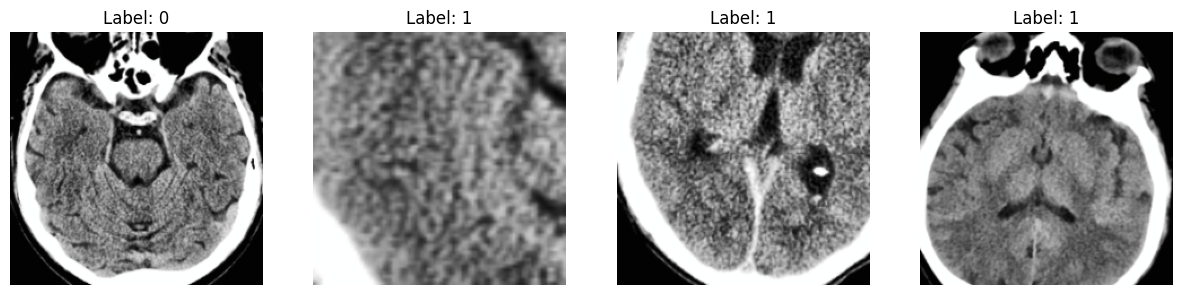

Validation Images:


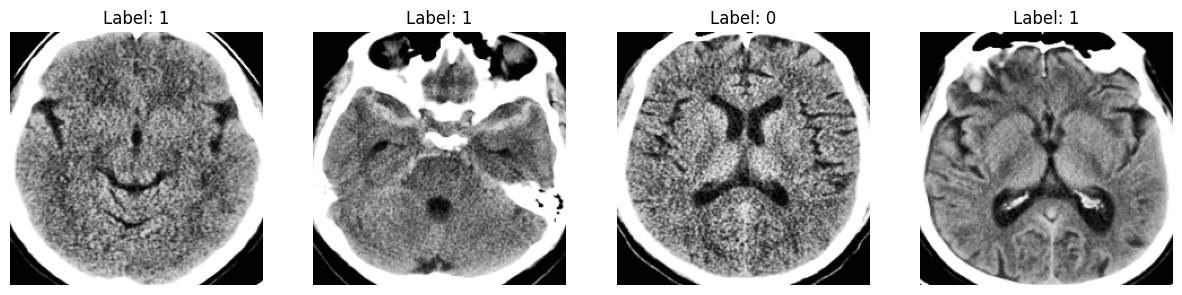

In [7]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## Truncation Densnet161


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class AttentiveDenseNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AttentiveDenseNet, self).__init__()
        
        # Load the densenet161 model
        densenet = models.densenet161(pretrained=True)
        
        # Truncate the densenet161 model
        features_children = list(densenet.features.children())
        truncated_features_children = features_children[:-2]
        self.features = nn.Sequential(*truncated_features_children)

        # Disable gradient computation for the truncated densenet
        for param in self.features.parameters():
            param.requires_grad = False

        # Linear layer before the multi-head attention mechanism
        self.linear = nn.Linear(1056, 512)  # 2208 should match the output dimensions of truncated densenet

        # Multi-head attention mechanism
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=16)

        # Classifier
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        
        # Extract features using the truncated densenet
        features = self.features(x)
        features = F.adaptive_avg_pool2d(features, (1, 1)).reshape(batch_size, -1)  # Global Average Pooling
        features = self.linear(features)

        # Preparing features for the attention mechanism
        features = features.unsqueeze(0)  # Adding seq_len of size 1

        # Multi-head attention mechanism
        attended_features, _ = self.attention(features, features, features)
        attended_features = attended_features.mean(dim=0)  # Global average pooling

        # Classifier
        fc_output = self.fc1(attended_features)
        fc_output = F.relu(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = F.relu(fc_output)
        fc_output = self.fc3(fc_output)
        fc_output = F.relu(fc_output)
        output = self.fc4(fc_output)

        return output

model = AttentiveDenseNet(num_classes=2).to(device)
model


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttentiveDenseNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace

In [9]:
for name, param in model.named_parameters():
    print(name, ":", param.requires_grad)

features.0.weight : False
features.1.weight : False
features.1.bias : False
features.4.denselayer1.norm1.weight : False
features.4.denselayer1.norm1.bias : False
features.4.denselayer1.conv1.weight : False
features.4.denselayer1.norm2.weight : False
features.4.denselayer1.norm2.bias : False
features.4.denselayer1.conv2.weight : False
features.4.denselayer2.norm1.weight : False
features.4.denselayer2.norm1.bias : False
features.4.denselayer2.conv1.weight : False
features.4.denselayer2.norm2.weight : False
features.4.denselayer2.norm2.bias : False
features.4.denselayer2.conv2.weight : False
features.4.denselayer3.norm1.weight : False
features.4.denselayer3.norm1.bias : False
features.4.denselayer3.conv1.weight : False
features.4.denselayer3.norm2.weight : False
features.4.denselayer3.norm2.bias : False
features.4.denselayer3.conv2.weight : False
features.4.denselayer4.norm1.weight : False
features.4.denselayer4.norm1.bias : False
features.4.denselayer4.conv1.weight : False
features.4.den

In [10]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                             Param #
AttentiveDenseNet                                  --
├─Sequential: 1-1                                  --
│    └─Conv2d: 2-1                                 (14,112)
│    └─BatchNorm2d: 2-2                            (192)
│    └─ReLU: 2-3                                   --
│    └─MaxPool2d: 2-4                              --
│    └─_DenseBlock: 2-5                            --
│    │    └─_DenseLayer: 3-1                       (101,952)
│    │    └─_DenseLayer: 3-2                       (111,264)
│    │    └─_DenseLayer: 3-3                       (120,576)
│    │    └─_DenseLayer: 3-4                       (129,888)
│    │    └─_DenseLayer: 3-5                       (139,200)
│    │    └─_DenseLayer: 3-6                       (148,512)
│    └─_Transition: 2-6                            --
│    │    └─BatchNorm2d: 3-7                       (768)
│    │    └─ReLU: 3-8                              --
│    │    └─Conv2d: 3-9

In [11]:
import time
import copy
from tqdm.auto import tqdm

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                _, preds = torch.max(outputs.detach(), 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history


In [13]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
train Loss: 0.6644 Acc: 0.6052


  2%|▏         | 1/50 [00:46<38:05, 46.64s/it]

valid Loss: 0.6275 Acc: 0.6440

Epoch 2/50
----------
train Loss: 0.6136 Acc: 0.6770


  4%|▍         | 2/50 [01:27<34:35, 43.25s/it]

valid Loss: 0.6491 Acc: 0.6599

Epoch 3/50
----------
train Loss: 0.5957 Acc: 0.6877


  6%|▌         | 3/50 [02:08<32:59, 42.11s/it]

valid Loss: 0.5920 Acc: 0.6767

Epoch 4/50
----------
train Loss: 0.5822 Acc: 0.6995


  8%|▊         | 4/50 [02:50<32:11, 41.99s/it]

valid Loss: 0.5970 Acc: 0.6893

Epoch 5/50
----------
train Loss: 0.5813 Acc: 0.6980


 10%|█         | 5/50 [03:30<30:59, 41.32s/it]

valid Loss: 0.5765 Acc: 0.6952

Epoch 6/50
----------
train Loss: 0.5511 Acc: 0.7224


 12%|█▏        | 6/50 [04:10<29:57, 40.86s/it]

valid Loss: 0.5714 Acc: 0.6986

Epoch 7/50
----------
train Loss: 0.5515 Acc: 0.7180


 14%|█▍        | 7/50 [04:49<28:59, 40.46s/it]

valid Loss: 0.5734 Acc: 0.7028

Epoch 8/50
----------
train Loss: 0.5519 Acc: 0.7199


 16%|█▌        | 8/50 [05:31<28:34, 40.83s/it]

valid Loss: 0.5729 Acc: 0.6969

Epoch 9/50
----------
train Loss: 0.5506 Acc: 0.7199


 18%|█▊        | 9/50 [06:12<28:01, 41.01s/it]

valid Loss: 0.5707 Acc: 0.7011

Epoch 10/50
----------
train Loss: 0.5551 Acc: 0.7201


 20%|██        | 10/50 [06:54<27:29, 41.24s/it]

valid Loss: 0.5786 Acc: 0.6961

Epoch 11/50
----------
train Loss: 0.5423 Acc: 0.7243


 22%|██▏       | 11/50 [07:34<26:31, 40.81s/it]

valid Loss: 0.5765 Acc: 0.6952

Epoch 12/50
----------
train Loss: 0.5487 Acc: 0.7144


 24%|██▍       | 12/50 [08:12<25:24, 40.11s/it]

valid Loss: 0.5789 Acc: 0.6961

Epoch 13/50
----------
train Loss: 0.5423 Acc: 0.7318


 26%|██▌       | 13/50 [08:51<24:31, 39.77s/it]

valid Loss: 0.5763 Acc: 0.6961

Epoch 14/50
----------
train Loss: 0.5464 Acc: 0.7268


 28%|██▊       | 14/50 [09:30<23:38, 39.41s/it]

valid Loss: 0.5706 Acc: 0.6986

Epoch 15/50
----------
train Loss: 0.5443 Acc: 0.7278


 30%|███       | 15/50 [10:09<22:50, 39.16s/it]

valid Loss: 0.5663 Acc: 0.7019

Epoch 16/50
----------
train Loss: 0.5408 Acc: 0.7249


 32%|███▏      | 16/50 [10:47<22:04, 38.97s/it]

valid Loss: 0.5718 Acc: 0.6961

Epoch 17/50
----------
train Loss: 0.5431 Acc: 0.7236


 34%|███▍      | 17/50 [11:26<21:26, 38.99s/it]

valid Loss: 0.5793 Acc: 0.6977

Epoch 18/50
----------
train Loss: 0.5525 Acc: 0.7152


 36%|███▌      | 18/50 [12:05<20:42, 38.84s/it]

valid Loss: 0.5782 Acc: 0.6944

Epoch 19/50
----------
train Loss: 0.5511 Acc: 0.7161


 38%|███▊      | 19/50 [12:43<20:01, 38.76s/it]

valid Loss: 0.5694 Acc: 0.7028

Epoch 20/50
----------
train Loss: 0.5479 Acc: 0.7207


 40%|████      | 20/50 [13:22<19:21, 38.71s/it]

valid Loss: 0.5710 Acc: 0.6944

Epoch 21/50
----------
train Loss: 0.5544 Acc: 0.7123


 42%|████▏     | 21/50 [14:00<18:40, 38.62s/it]

valid Loss: 0.5746 Acc: 0.6994

Epoch 22/50
----------
train Loss: 0.5438 Acc: 0.7287


 44%|████▍     | 22/50 [14:39<18:00, 38.61s/it]

valid Loss: 0.5767 Acc: 0.6986

Epoch 23/50
----------
train Loss: 0.5498 Acc: 0.7197


 46%|████▌     | 23/50 [15:17<17:22, 38.59s/it]

valid Loss: 0.5691 Acc: 0.7028

Epoch 24/50
----------
train Loss: 0.5495 Acc: 0.7236


 48%|████▊     | 24/50 [15:56<16:43, 38.59s/it]

valid Loss: 0.5724 Acc: 0.6961

Epoch 25/50
----------
train Loss: 0.5464 Acc: 0.7268


 50%|█████     | 25/50 [16:35<16:04, 38.59s/it]

valid Loss: 0.5735 Acc: 0.7003

Epoch 26/50
----------
train Loss: 0.5425 Acc: 0.7260


 52%|█████▏    | 26/50 [17:13<15:26, 38.59s/it]

valid Loss: 0.5778 Acc: 0.6986

Epoch 27/50
----------
train Loss: 0.5425 Acc: 0.7255


 54%|█████▍    | 27/50 [17:52<14:51, 38.76s/it]

valid Loss: 0.5739 Acc: 0.6944

Epoch 28/50
----------
train Loss: 0.5461 Acc: 0.7220


 56%|█████▌    | 28/50 [18:31<14:11, 38.69s/it]

valid Loss: 0.5738 Acc: 0.6961

Epoch 29/50
----------
train Loss: 0.5443 Acc: 0.7291


 58%|█████▊    | 29/50 [19:09<13:31, 38.66s/it]

valid Loss: 0.5706 Acc: 0.6944

Epoch 30/50
----------
train Loss: 0.5406 Acc: 0.7278


 60%|██████    | 30/50 [19:48<12:52, 38.61s/it]

valid Loss: 0.5695 Acc: 0.7003

Epoch 31/50
----------
train Loss: 0.5467 Acc: 0.7245


 62%|██████▏   | 31/50 [20:26<12:12, 38.56s/it]

valid Loss: 0.5696 Acc: 0.6986

Epoch 32/50
----------
train Loss: 0.5488 Acc: 0.7289


 64%|██████▍   | 32/50 [21:05<11:34, 38.61s/it]

valid Loss: 0.5709 Acc: 0.6977

Epoch 33/50
----------
train Loss: 0.5456 Acc: 0.7304


 66%|██████▌   | 33/50 [21:43<10:55, 38.57s/it]

valid Loss: 0.5719 Acc: 0.6927

Epoch 34/50
----------
train Loss: 0.5482 Acc: 0.7178


 68%|██████▊   | 34/50 [22:22<10:16, 38.55s/it]

valid Loss: 0.5695 Acc: 0.6986

Epoch 35/50
----------
train Loss: 0.5526 Acc: 0.7182


 70%|███████   | 35/50 [23:01<09:38, 38.55s/it]

valid Loss: 0.5656 Acc: 0.7053

Epoch 36/50
----------
train Loss: 0.5406 Acc: 0.7316


 72%|███████▏  | 36/50 [23:39<09:00, 38.60s/it]

valid Loss: 0.5708 Acc: 0.6935

Epoch 37/50
----------
train Loss: 0.5483 Acc: 0.7257


 74%|███████▍  | 37/50 [24:18<08:21, 38.54s/it]

valid Loss: 0.5729 Acc: 0.6927

Epoch 38/50
----------
train Loss: 0.5473 Acc: 0.7281


 76%|███████▌  | 38/50 [24:56<07:42, 38.56s/it]

valid Loss: 0.5692 Acc: 0.6986

Epoch 39/50
----------
train Loss: 0.5419 Acc: 0.7291


 78%|███████▊  | 39/50 [25:35<07:04, 38.55s/it]

valid Loss: 0.5821 Acc: 0.6944

Epoch 40/50
----------
train Loss: 0.5476 Acc: 0.7236


 80%|████████  | 40/50 [26:13<06:25, 38.53s/it]

valid Loss: 0.5686 Acc: 0.6969

Epoch 41/50
----------
train Loss: 0.5471 Acc: 0.7197


 82%|████████▏ | 41/50 [26:52<05:47, 38.60s/it]

valid Loss: 0.5744 Acc: 0.6977

Epoch 42/50
----------
train Loss: 0.5435 Acc: 0.7251


 84%|████████▍ | 42/50 [27:31<05:08, 38.57s/it]

valid Loss: 0.5697 Acc: 0.7019

Epoch 43/50
----------
train Loss: 0.5489 Acc: 0.7215


 86%|████████▌ | 43/50 [28:09<04:29, 38.56s/it]

valid Loss: 0.5732 Acc: 0.6919

Epoch 44/50
----------
train Loss: 0.5480 Acc: 0.7257


 88%|████████▊ | 44/50 [28:48<03:51, 38.56s/it]

valid Loss: 0.5694 Acc: 0.6994

Epoch 45/50
----------
train Loss: 0.5492 Acc: 0.7182


 90%|█████████ | 45/50 [29:26<03:12, 38.56s/it]

valid Loss: 0.5711 Acc: 0.6961

Epoch 46/50
----------
train Loss: 0.5485 Acc: 0.7218


 92%|█████████▏| 46/50 [30:05<02:34, 38.54s/it]

valid Loss: 0.5831 Acc: 0.6952

Epoch 47/50
----------
train Loss: 0.5440 Acc: 0.7268


 94%|█████████▍| 47/50 [30:43<01:55, 38.53s/it]

valid Loss: 0.5718 Acc: 0.6944

Epoch 48/50
----------
train Loss: 0.5530 Acc: 0.7228


 96%|█████████▌| 48/50 [31:22<01:17, 38.57s/it]

valid Loss: 0.5793 Acc: 0.6977

Epoch 49/50
----------
train Loss: 0.5542 Acc: 0.7211


 98%|█████████▊| 49/50 [32:00<00:38, 38.53s/it]

valid Loss: 0.5731 Acc: 0.6977

Epoch 50/50
----------
train Loss: 0.5464 Acc: 0.7276


100%|██████████| 50/50 [32:39<00:00, 39.19s/it]

valid Loss: 0.5686 Acc: 0.6994

Training complete in 32m 41s
Best valid accuracy: 0.705290


In [14]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[580 103]
 [248 260]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       683
           1       0.72      0.51      0.60       508

    accuracy                           0.71      1191
   macro avg       0.71      0.68      0.68      1191
weighted avg       0.71      0.71      0.69      1191



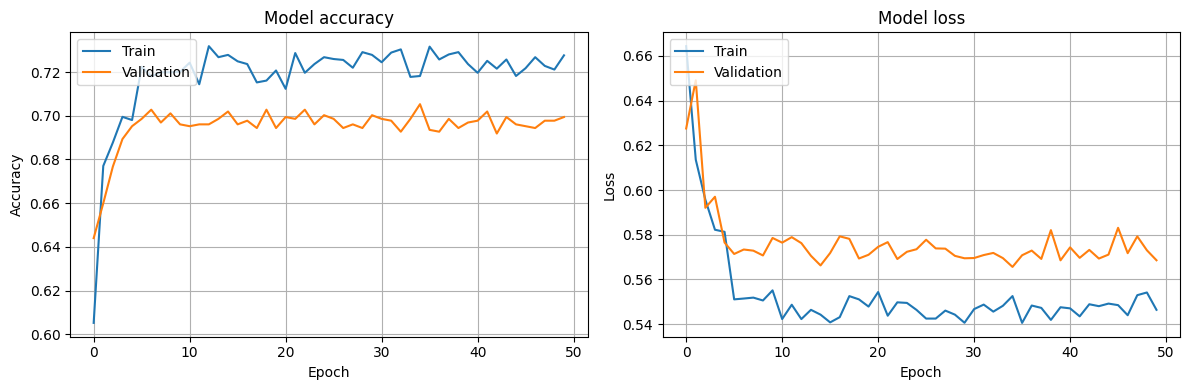

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Unfreez the whole model for fine-tuning

In [58]:
for param in model.parameters():
    param.requires_grad = True

In [59]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


In [33]:
# Save Model
bestmodel = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'HemorrhageDensnet_Truncate.pth')

In [34]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

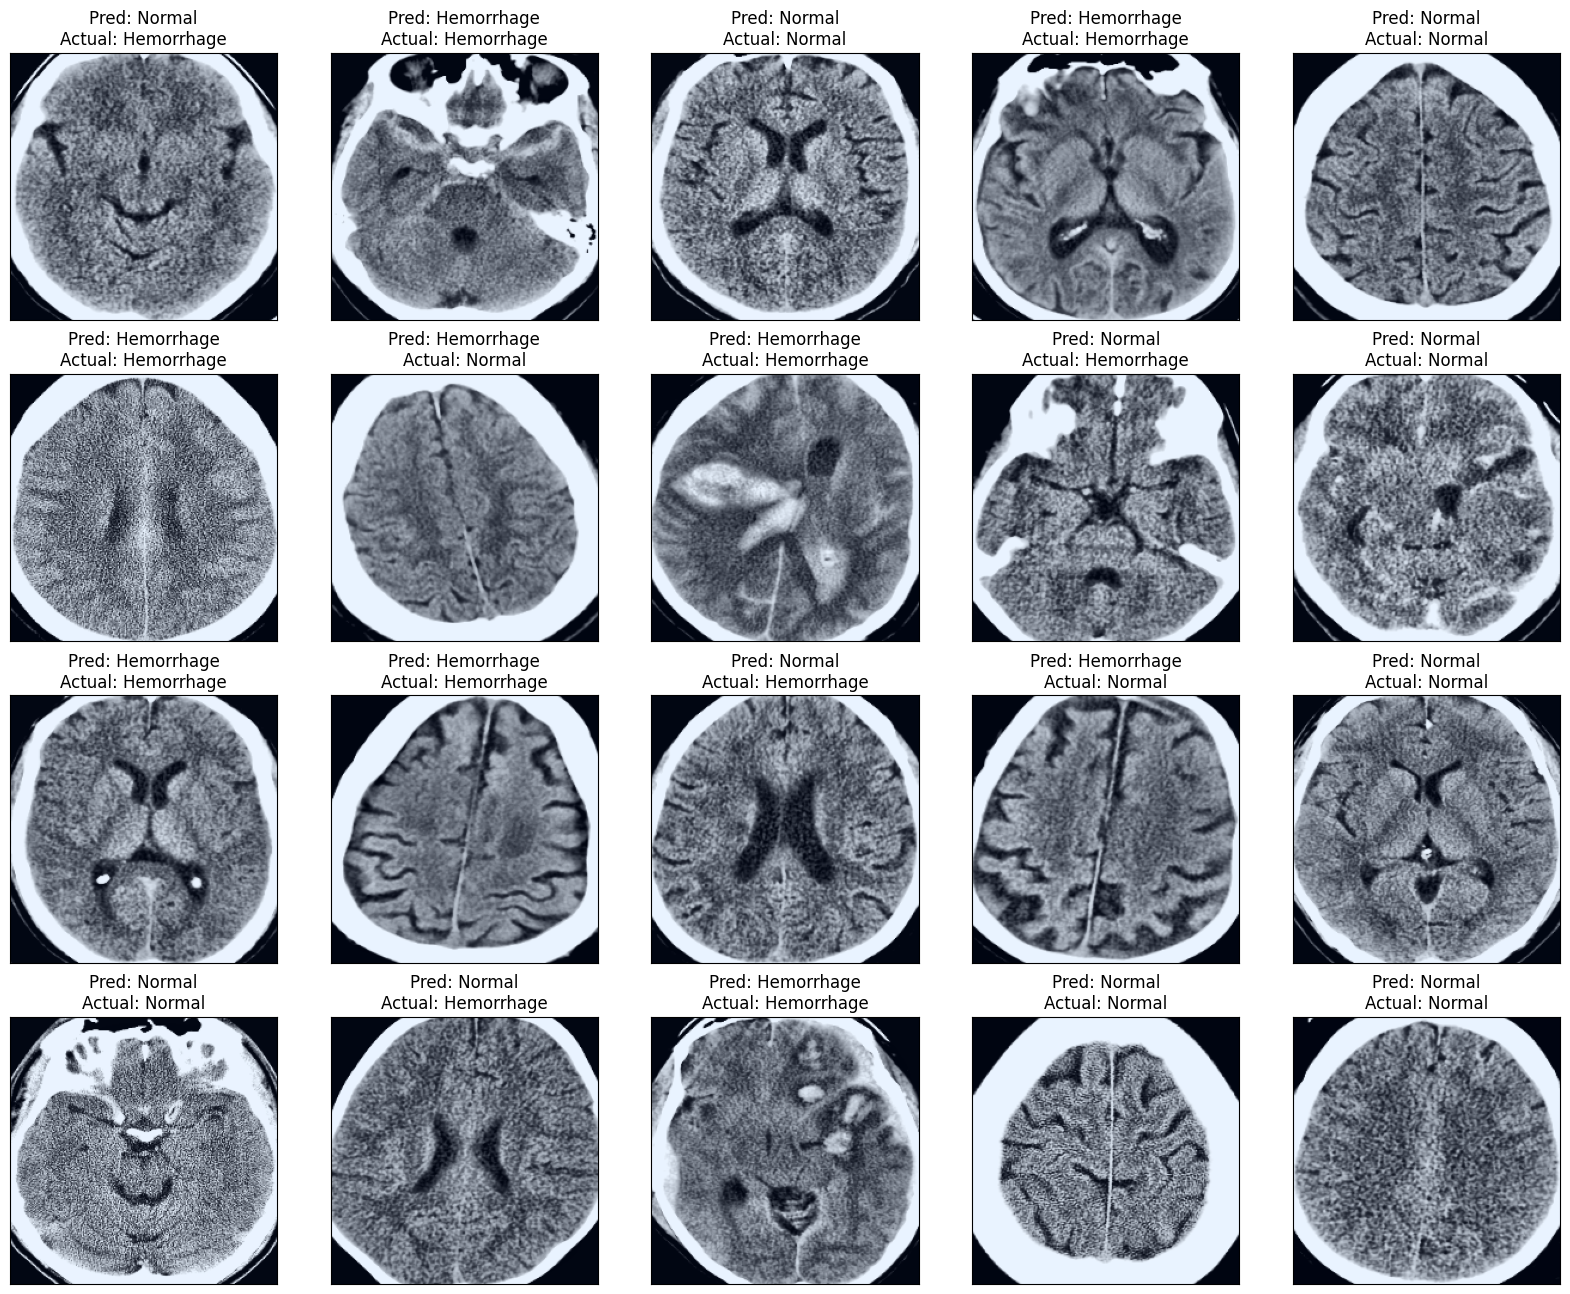

In [40]:
# Switch the model to evaluation mode
model.eval()

# Define a function to display images and predictions
def display_predictions(model, dataloader, num_images=20):
    # Ensure we have enough images to display
    assert len(dataloader.dataset) >= num_images, "Not enough samples in the dataloader."
    
    # Get batches of data until we have enough images
    images_list, labels_list = [], []
    for images, labels in dataloader:
        images_list.append(images)
        labels_list.append(labels)
        if len(images_list) * len(images_list[0]) >= num_images:
            break
    
    images = torch.cat(images_list)[:num_images]
    labels = torch.cat(labels_list)[:num_images]
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']  # Replace with your class names
    
    # Plot the images with their predictions and actual labels
    fig = plt.figure(figsize=(20, 4 * (num_images // 5)))
    for i in range(num_images):
        ax = fig.add_subplot(num_images // 5, 5, i+1, xticks=[], yticks=[])
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Denormalize
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}")

# Display predictions
display_predictions(model, dataloaders['valid'])


The predicted class for the image is: Normal
Probabilities for each class:
Normal: 64.98%
Hemorrhage: 35.02%


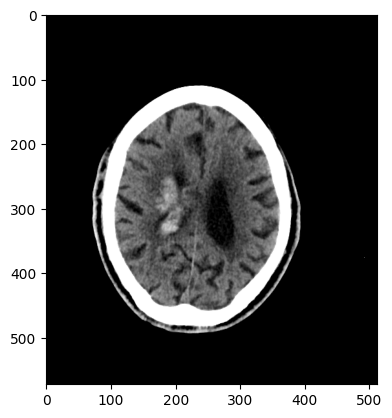

In [54]:
import torch.nn.functional as F

def predict_image_class_with_probabilities(model, image_path, transform):
    """
    Predict the class of an image and return the probabilities for each class.

    Parameters:
    - model: Trained PyTorch model.
    - image_path: Path to the image file (JPG or PNG).
    - transform: Image transformations to apply before prediction.

    Returns:
    - predicted_class: Predicted class label.
    - class_probabilities: Probabilities for each class.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformations
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)[0] * 100  # Convert to percentages
        _, predicted_idx = torch.max(output, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']  # Replace with your class names
    predicted_class = class_names[predicted_idx.item()]
    
    class_probabilities = {class_name: prob.item() for class_name, prob in zip(class_names, probabilities)}
    
    return predicted_class, class_probabilities

# Example usage
image_path = r"Test/slice_19.png"
image = Image.open(image_path)
plt.imshow(image)

predicted_class, class_probabilities = predict_image_class_with_probabilities(model, image_path, data_transforms['val'])
print(f"The predicted class for the image is: {predicted_class}")
print("Probabilities for each class:")
for class_name, prob in class_probabilities.items():
    print(f"{class_name}: {prob:.2f}%")
